In [1]:
from __future__ import print_function, division

import numpy as np
from keras import backend as K
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import layers, models
from keras import losses

from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

# visualization
import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# sys and helpers
import sys
import os

os.environ["CUDA_DEVISE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import glob
from tqdm import tqdm

print('Modules imported.')



datasets = 'mnist'

if datasets=='mnist':
    img_rows = 28
    img_cols = 28
    channels = 1
    img_shape = (img_rows, img_cols, channels)
elif datasets=='cifar10':
    img_rows = 32
    img_cols = 32
    channels = 3
    img_shape = (img_rows, img_cols, channels)
    
num_classes = 10
latent_dim = 100
routings = 3
# # device check
# from tensorflow.python.client import device_lib
# print('Devices:', device_lib.list_local_devices())

# # GPU check
# if not tf.test.gpu_device_name():
#     print('No GPU found.')
# else:
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Using TensorFlow backend.


Modules imported.


In [2]:
## Margin Loss

In [3]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

## Defining the model

In [4]:
# discriminator structure
def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.summary()

    img = Input(shape=img_shape)

    # Extract feature representation
    features = model(img)


    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid", name='ds')(features)
    label = Dense(num_classes, activation="softmax", name='label')(features)

    return Model(img, [validity, label])

In [5]:
optimizer = Adam(0.0002, 0.5)
losses1 = ['binary_crossentropy', 'categorical_crossentropy']
# losses1 =[]
# losses1.append(losses.binary_crossentropy)
# losses1.append(margin_loss)
# Build and compile the discriminator
discriminator = build_discriminator()
print('DISCRIMINATOR:')
discriminator.summary()

discriminator.compile(loss=losses1, optimizer=optimizer, metrics={'label':'accuracy', 'ds':'accuracy'})


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

In [6]:
# generator structure
def build_generator():

    """
    Generator follows the DCGAN architecture and creates generated image representations through learning.
    """


    # we apply different kernel sizes in order to match the original image size
    
    if datasets=='mnist':
#         noise = Input(shape=(latent_dim,))
#         label = Input(shape=(1,), dtype='int32')

#         label_embedding = Flatten()(Embedding(num_classes, 100)(label))

#         model_input = multiply([noise, label_embedding])

#         x = Dense(14 * 14 * 1, activation="relu")(model_input)
#         x = Reshape((14, 14, 1))(x)
#         x = BatchNormalization(momentum=0.8)(x)
#         x = UpSampling2D()(x)
#         x = Conv2D(64, kernel_size=9, strides=1, padding="valid")(x)
#         x = LeakyReLU(alpha=0.2)(x)
#         x = BatchNormalization(momentum=0.8)(x)
# #         x = UpSampling2D()(x)
# #         x = Conv2D(64, kernel_size=3, padding="same")(x)
# #         x = LeakyReLU(alpha=0.2)(x)
# #         x = BatchNormalization(momentum=0.8)(x)
#         x = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
#         x = CapsuleLayer(num_capsule=10, dim_capsule=98, routings=routings)(x)
# #         x = Mask()(x)
# #         y = layers.Input(shape=(num_classes,))
# #         x = Mask()([x, y])
#         x = Flatten()(x)

#         x = Reshape((7, 7, 20))(x)
#         x = BatchNormalization(momentum=0.8)(x)
#         x = UpSampling2D()(x)
#         x = Conv2D(128, kernel_size=3, padding="same")(x)
#         x = LeakyReLU(alpha=0.2)(x)
#         x = BatchNormalization(momentum=0.8)(x)
#         x = UpSampling2D()(x)
#         x = Conv2D(channels, kernel_size=3, padding="same")(x)
#         img = Activation("tanh")(x)
        
#         return Model([noise, label], img)
#         return Model([noise, y], img)

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(512, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))
        model.summary()

        noise = Input(shape=(latent_dim,))
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])

        img = model(model_input)

        return Model([noise, label], img)

        
    if datasets=='cifar10':
#         noise = Input(shape=(latent_dim,))
#         label = Input(shape=(1,), dtype='int32')

#         label_embedding = Flatten()(Embedding(num_classes, 100)(label))

#         model_input = multiply([noise, label_embedding])

#         x = Dense(16 * 16 * 1, activation="relu")(model_input)
#         x = Reshape((16, 16, 1))(x)
#         x = BatchNormalization(momentum=0.8)(x)
#         x = UpSampling2D()(x)
#         x = Conv2D(64, kernel_size=9, strides=1, padding="valid")(x)
#         x = LeakyReLU(alpha=0.2)(x)
#         x = BatchNormalization(momentum=0.8)(x)
# #         x = UpSampling2D()(x)
# #         x = Conv2D(64, kernel_size=3, padding="same")(x)
# #         x = LeakyReLU(alpha=0.2)(x)
# #         x = BatchNormalization(momentum=0.8)(x)
#         x = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
#         x = CapsuleLayer(num_capsule=10, dim_capsule=64, routings=routings)(x)
# #         x = Mask()(x)
# #         y = layers.Input(shape=(num_classes,))
# #         x = Mask()([x, y])
#         x = Flatten()(x)

#         x = Reshape((8, 8, 10))(x)
#         x = BatchNormalization(momentum=0.8)(x)
#         x = UpSampling2D()(x)
#         x = Conv2D(128, kernel_size=3, padding="same")(x)
#         x = LeakyReLU(alpha=0.2)(x)
#         x = BatchNormalization(momentum=0.8)(x)
#         x = UpSampling2D()(x)
#         x = Conv2D(channels, kernel_size=3, padding="same")(x)
#         img = Activation("tanh")(x)
        
#         return Model([noise, label], img)
        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(512, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(channels, kernel_size=3, padding='same'))

        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(latent_dim,))
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])

        img = model(model_input)

        return Model([noise, label], img)

In [7]:
# Build the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))

img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
valid, target_label = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
combined = Model([noise, label], [valid, target_label])
combined.compile(loss=losses1, optimizer=optimizer)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 512)       590336    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 512)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 512)       2048      
__________

## Training

In [8]:
# loss values for further plotting
D_L_REAL = []
D_L_FAKE = []
D_L = []
D_ACC = []
G_L = []
Class_Acc = []
sample_z = []
pdf_x = []
fake_pred = []

In [9]:
def train(dataset, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    if dataset=='mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        X_test = np.expand_dims(X_test, axis=3)
        y_test = y_test.reshape(-1, 1)
    elif dataset=='cifar10':
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#         X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
#         X_test = np.expand_dims(X_test, axis=3)
        y_test = y_test.reshape(-1, 1)
#     # Rescale -1 to 1
#     X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#     X_train = np.expand_dims(X_train, axis=3)
#     y_train = y_train.reshape(-1, 1)
    
#     X_test = (X_test.astype(np.float32) - 127.5) / 127.5
#     X_test = np.expand_dims(X_test, axis=3)
#     y_test = y_test.reshape(-1, 1)


    ## Pre-train
    valid = np.ones((60000,1))
    y_tr = to_categorical(y_train, num_classes=num_classes)
    discriminator.fit(x=X_train, y=[valid, y_tr], batch_size=128, epochs=1)
    discriminator.save_weights('saved_model'+ '/trained_'+datasets+'_convdiscriminator_1epoch_10class.h5')
#     discriminator.load_weights('saved_model'+ '/trained_discriminator_cur_1epoch_10class2.h5')

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # The labels of the digits that the generator tries to create an
        # image representation of
        sampled_labels = np.random.randint(0, 10, half_batch).reshape(-1, 1)
#         sampled_labels = to_categorical(sampled_labels, num_classes=num_classes)
        
        # Generate a half batch of new images
        gen_imgs = generator.predict([noise, sampled_labels])
#         valid = np.ones((half_batch, 1))
#         fake = np.zeros((half_batch, 1))
        
        valid = np.random.uniform(0.7,1.2,(half_batch,1))
        fake = np.random.uniform(0.0,0.3,(half_batch,1))
            
        # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
        img_labels = y_train[idx]
        img_labels1 = to_categorical(img_labels, num_classes=num_classes)
        img_l = np.random.uniform(0.7,1.0,img_labels1.shape)
        img_labels2 = np.multiply(img_labels1, img_l)
        
        fake_labels = np.zeros((half_batch, num_classes))
#         fake_labels = sampled_labels
#         fake_labels1 = to_categorical(fake_labels, num_classes=num_classes)
#         fake_l = np.random.uniform(0.7, 1.0,fake_labels1.shape)
#         fake_labels2 = np.multiply(fake_labels1, fake_l)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([imgs], [valid, img_labels2])
        d_loss_fake = discriminator.train_on_batch([gen_imgs], [fake, fake_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        ft = 1
        # Sample generator input
        noise = np.random.normal(0, 1, (batch_size*ft, 100))
        valid = np.ones((batch_size*ft, 1))
        # Generator wants discriminator to label the generated images as the intended
        # digits
        sampled_labels = np.random.randint(0, 10, batch_size*ft).reshape(-1, 1)
        sampled_labels1 = to_categorical(sampled_labels, num_classes=num_classes)
#         sampled_labels = to_categorical(sampled_labels, num_classes=num_classes)

        # Train the generator
        g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels1])

        # Plot the progress
        print ("%d %s %s %s %s %s" %(epoch, discriminator.metrics_names[0], discriminator.metrics_names[1], discriminator.metrics_names[2], discriminator.metrics_names[3], discriminator.metrics_names[4]))
        print ("   %f %f %f %.2f %.2f" % (d_loss[0], d_loss[1], d_loss[2], d_loss[3], d_loss[4]))
#         print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
# #         print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
#         print ("%d [D_real loss: %f, acc.: %.2f%%]" % (epoch, d_loss_real[0], 100*d_loss_real[1]))
#         print ("%d [D_fake loss: %f, acc.: %.2f%%]" % (epoch, d_loss_fake[0], 100*d_loss_fake[1]))
        D_L_REAL.append(d_loss_real)
        D_L_FAKE.append(d_loss_fake)
        D_L.append(d_loss)
        D_ACC.append(d_loss[1])
        G_L.append(g_loss)
        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            save_model()
            sample_images(epoch)
            
            valid1 = np.ones((y_test.size, 1))

            img_labels1 = y_test
            img_labels1 = to_categorical(img_labels1, num_classes=num_classes)

            # test the discriminator
#             discriminator.trainable = False
#             discriminator.save_weights('saved_model'+ '/trained_discriminator_cur.h5')
#             discriminator_eval.load_weights('saved_model'+ '/trained_discriminator_cur.h5')
            test_acc = discriminator.evaluate(X_test, [valid1, img_labels1])
#             discriminator.trainable = True
#             print(test_acc)
            print("Test Accuracy = %.2f " %(test_acc[4]*100))
            Class_Acc.append(test_acc[4])
        
#             tst = 5000
#             valid = np.ones((tst,1))
#             idx = np.random.randint(0, X_train.shape[0], tst)
#             imgs = X_train[idx]
#             y_imgs = y_train[idx]
#             y_tr = to_categorical(y_imgs, num_classes=num_classes)
#             discriminator.fit(x=imgs, y=[valid, y_tr], batch_size=128, epochs=1)
            

In [10]:
def sample_images(epoch):
    r, c = 5, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])
#     sampled_labels = to_categorical(sampled_labels, num_classes=num_classes)
    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            if datasets == 'mnist':
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
            elif datasets == 'cifar10':
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
    fig.savefig("images_conv_%s/%d.png" % (datasets,epoch))
    plt.close()

def save_model():

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                        "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])
    
    save(generator, datasets+"_convgan_generator")
    save(discriminator, datasets+"_convgan_discriminator")
    save(combined, datasets+"_convgan_adversarial")

In [11]:
history = train(datasets, epochs=5000, batch_size=32, sample_interval=200)


Epoch 1/1
60000/60000 [==============================] - 15s - loss: 0.4717 - ds_loss: 0.0051 - label_loss: 0.4666 - ds_acc: 0.9988 - label_acc: 0.8515      

## Visualizations

In [12]:
discriminator.trainable

np.savez(datasets+'convgan.npz',Class_Acc=Class_Acc, D_L=D_L, G_L=G_L, D_L_REAL=D_L_REAL, D_L_FAKE=D_L_FAKE)

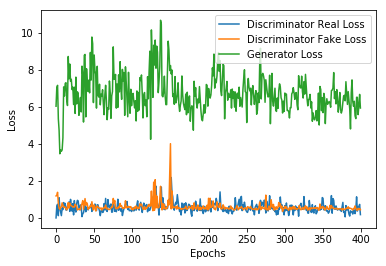

In [14]:
tmp_rdl = []
tmp_fdl = []
tmp_gl = []
tmp_n = np.size(D_L)/2
tmp_n = 4000
for i in range(tmp_n):
    tmp_rdl.append(D_L_REAL[i][0])
    tmp_fdl.append(D_L_FAKE[i][0])
    tmp_gl.append(G_L[i][0])
    
# fig, ax = plt.figure()
plt.plot(tmp_rdl)
plt.plot(tmp_fdl)
plt.plot(tmp_gl)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Discriminator Real Loss','Discriminator Fake Loss', 'Generator Loss'])
plt.savefig(datasets+'convgan_all_loss.png')
plt.show()


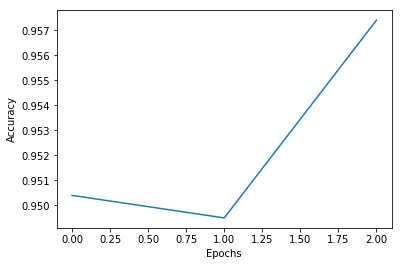

In [17]:
# fig, ax = plt.figure()
plt.plot(Class_Acc)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig(datasets+'convgan_Classification_Accuracy.png')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 512)       590336    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 512)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 512)       2048      
__________

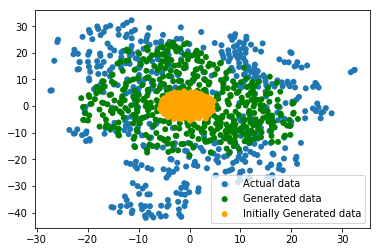

In [16]:
from sklearn.manifold import TSNE
num_samps = 500
if datasets=='mnist':
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
        # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)
        # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], num_samps)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (num_samps, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
    sampled_labels = np.random.randint(0, 10, num_samps).reshape(-1, 1)
#     sampled_labels = to_categorical(sampled_labels, num_classes=num_classes)
            # Generate a half batch of new images
    gen_imgs = generator.predict([noise, sampled_labels])

    # idx = np.random.randint(0, dataset.shape[0], 1000)
    # pdf_x = dataset[idx]
    pdf_x = imgs.reshape([-1, 28*28])
    sample_z = noise
    fake_pred = gen_imgs.reshape([-1, 28*28])

    generator1 = build_generator()
    generator1.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    fake_pred_i  = generator1.predict([noise, sampled_labels])
    fake_pred_i = fake_pred_i.reshape([-1, 28*28])

    t0 = TSNE(n_components=2).fit_transform(fake_pred_i)
    t1 = TSNE(n_components=2).fit_transform(pdf_x)
    t2 = TSNE(n_components=2).fit_transform(fake_pred)


    _ = plt.scatter(t1[:,0], t1[:,1], edgecolor='none')
    _ = plt.scatter(t2[:,0], t2[:,1], color='green', edgecolor='none')
    _ = plt.scatter(t0[:,0], t0[:,1], edgecolor='none', color='orange')
    plt.legend(['Actual data', 'Generated data', 'Initially Generated data'])
    plt.savefig(datasets+'convgan_all_distributions.png')
    plt.show()

elif datasets=='cifar10':
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#         X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], num_samps)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (num_samps, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
    sampled_labels = np.random.randint(0, 10, num_samps).reshape(-1, 1)
#     sampled_labels = to_categorical(sampled_labels, num_classes=num_classes)
            # Generate a half batch of new images
    gen_imgs = generator.predict([noise, sampled_labels])

    # idx = np.random.randint(0, dataset.shape[0], 1000)
    # pdf_x = dataset[idx]
    pdf_x = imgs.reshape([-1, 32*32*3])
    sample_z = noise
    fake_pred = gen_imgs.reshape([-1, 32*32*3])

    generator1 = build_generator()
    generator1.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    fake_pred_i  = generator1.predict([noise, sampled_labels])
    fake_pred_i = fake_pred_i.reshape([-1, 32*32*3])

    t0 = TSNE(n_components=2).fit_transform(fake_pred_i)
    t1 = TSNE(n_components=2).fit_transform(pdf_x)
    t2 = TSNE(n_components=2).fit_transform(fake_pred)


    _ = plt.scatter(t1[:,0], t1[:,1], edgecolor='none')
    _ = plt.scatter(t2[:,0], t2[:,1], color='green', edgecolor='none')
    _ = plt.scatter(t0[:,0], t0[:,1], edgecolor='none', color='orange')
    plt.legend(['Actual data', 'Generated data', 'Initially Generated data'])
    plt.savefig(datasets+'convgangan_all_distributions.png')
    plt.show()